In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from pathlib import Path
from PIL import Image
import torchvision.utils as vutils
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import math
from sklearn.metrics import accuracy_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
torch.cuda.device_count()

6

In [5]:
#from fastai code
def top_k_accuracy(input, targs, k=3):
    "Computes the Top-k accuracy (target is in the top k predictions)."
    input = input.topk(k=k, dim=-1)[1]
    targs = targs.unsqueeze(dim=-1).expand_as(input)
    return (input == targs).max(dim=-1)[0].float().mean()

In [6]:
image_size = 224
std,mean = [0.229, 0.224, 0.225],[0.485, 0.456, 0.406] # pretrained models used these values


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [7]:
def imshow(img, title='', std=std, mean=mean):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.figure (figsize = (16, 16))
    plt.imshow(img)
    plt.title(title)

In [8]:
class IFoodDataset(Dataset):
    def __init__(self, labels_csv, data_path, transforms):
        self.labels_df = pd.read_csv(labels_csv)
        self.data_path = root_path / data_path
        self.compose = transforms
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.data_path/self.labels_df.iloc[idx, 0]
        image = io.imread(img_name)
        image = Image.fromarray(image)
        image = self.compose(image)
        return {'image':image,'label':self.labels_df.iloc[idx, 1]}

In [23]:

bs=128
root_path = Path.cwd() / 'ifood' #Path('/home/yonatang/findmyfood/ifood')
train_labels_csv = 'train_labels.csv'
train_data_path = 'train_set'
train_dataset = IFoodDataset(root_path/train_labels_csv, root_path/train_data_path, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True,num_workers=4)
val_labels_csv = 'val_labels.csv'
val_data_path = 'val_set'
val_dataset = IFoodDataset(root_path/val_labels_csv, root_path/val_data_path, test_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=True,num_workers=4)

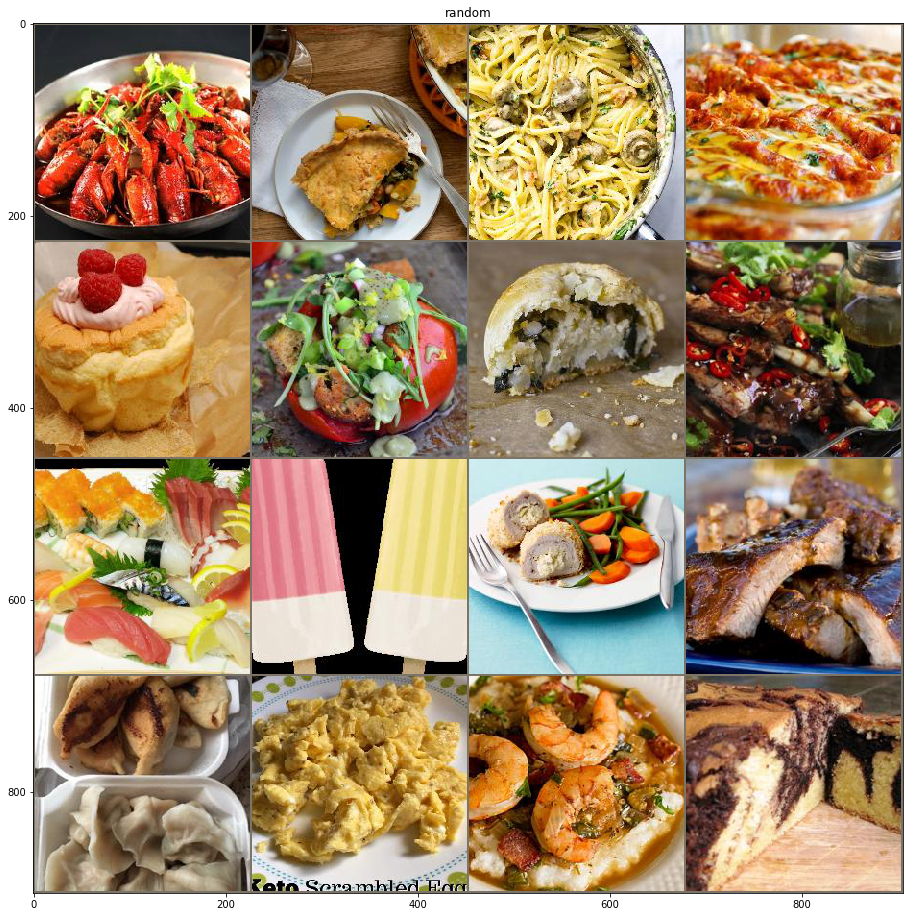

In [24]:
batch = next(iter(val_dataloader))
imshow(vutils.make_grid(batch['image'][:16], nrow=4, padding=2), 'random')

In [25]:
# fit/test functions
def fit(iterator, model, optimizer, criterion):
    train_loss = 0
    model.train()
    all_y = []
    all_y_hat = []
    for batch in tqdm(iterator,leave=False):
        optimizer.zero_grad()
        y_hat = model(batch['image'].to(device))
        loss = criterion(y_hat, batch['label'].to(device))
        train_loss += loss.item()*batch['image'].shape[0]
        loss.backward()
        optimizer.step()
        all_y.append(batch['label'])
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    acc = top_k_accuracy(y_hat.cpu(),y.cpu())
    return train_loss / len(iterator.dataset),acc

def test(iterator, model, criterion):
    train_loss = 0
    model.eval()
    all_y = []
    all_y_hat = []    
    for batch in tqdm(iterator,leave=False):                    
        with torch.no_grad():
            y_hat = model(batch['image'].to(device))
        loss = criterion(y_hat, batch['label'].to(device))
        train_loss += loss.item()*batch['image'].shape[0]
        all_y.append(batch['label'])
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    acc = top_k_accuracy(y_hat.cpu(),y.cpu())
    
    return train_loss / len(iterator.dataset),acc

In [26]:
def train_n_epochs(model, n, optimizer, train_dataloader, val_dataloader):
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in range(n):
        start_time = time.time()
        train_loss,train_acc = fit(train_dataloader, model, optimizer, criterion)
        valid_loss,valid_acc = test(val_dataloader, model, criterion)
   #     scheduler.step()
        secs = int(time.time() - start_time)
        print(f'epoch {epoch}. time: {secs}[s]')
        print(f'\ttrain loss: {train_loss:.4f} accuracy: {train_acc:.4f}')
        print(f'\tvalidation loss: {valid_loss:.4f} accuracy: {valid_acc:.4f}')

In [54]:
model = models.resnet34(pretrained=True)
# Start by freezing all but last liner layer. 
# Later unfreeze and finetune lower layers
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 251)
nn.init.kaiming_normal_(model.fc.weight)
nn.init.zeros_(model.fc.bias)
model = model.to(device)
model = nn.DataParallel(model).to(device)

In [55]:
wd=1e-6
lr=0.001
epochs=10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)

epoch 0. time: 294[s]
	train loss: 4.3053 accuracy: 0.2676
	validation loss: 3.0641 accuracy: 0.5029


epoch 1. time: 284[s]
	train loss: 3.4889 accuracy: 0.4242
	validation loss: 2.7959 accuracy: 0.5486


epoch 2. time: 284[s]
	train loss: 3.3404 accuracy: 0.4543
	validation loss: 2.6708 accuracy: 0.5766


epoch 3. time: 286[s]
	train loss: 3.2692 accuracy: 0.4692
	validation loss: 2.6508 accuracy: 0.5832


epoch 4. time: 282[s]
	train loss: 3.2267 accuracy: 0.4758
	validation loss: 2.6176 accuracy: 0.5868


epoch 5. time: 283[s]
	train loss: 3.1916 accuracy: 0.4835
	validation loss: 2.5773 accuracy: 0.5955


epoch 6. time: 285[s]
	train loss: 3.1749 accuracy: 0.4871
	validation loss: 2.5930 accuracy: 0.5920


epoch 7. time: 283[s]
	train loss: 3.1492 accuracy: 0.4911
	validation loss: 2.5460 accuracy: 0.5998


epoch 8. time: 284[s]
	train loss: 3.1385 accuracy: 0.4940
	validation loss: 2.5719 accuracy: 0.5980


epoch 9. time: 284[s]
	train loss: 3.1225 accuracy: 0.4985
	validation loss: 2.5189 accuracy: 0.6041


In [56]:
wd=1e-6
lr=1e-5
epochs=15
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.module.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)

epoch 0. time: 439[s]
	train loss: 2.7934 accuracy: 0.5612
	validation loss: 2.0342 accuracy: 0.7010


epoch 1. time: 440[s]
	train loss: 2.5984 accuracy: 0.5983
	validation loss: 1.9089 accuracy: 0.7259


epoch 2. time: 440[s]
	train loss: 2.4929 accuracy: 0.6200
	validation loss: 1.8519 accuracy: 0.7368


epoch 3. time: 427[s]
	train loss: 2.4135 accuracy: 0.6340
	validation loss: 1.7808 accuracy: 0.7510


epoch 4. time: 425[s]
	train loss: 2.3429 accuracy: 0.6472
	validation loss: 1.7433 accuracy: 0.7553


epoch 5. time: 426[s]
	train loss: 2.2904 accuracy: 0.6562
	validation loss: 1.6710 accuracy: 0.7685


epoch 6. time: 427[s]
	train loss: 2.2445 accuracy: 0.6645
	validation loss: 1.6349 accuracy: 0.7764


epoch 7. time: 425[s]
	train loss: 2.2014 accuracy: 0.6720
	validation loss: 1.6247 accuracy: 0.7798


epoch 8. time: 425[s]
	train loss: 2.1572 accuracy: 0.6802
	validation loss: 1.5884 accuracy: 0.7859


epoch 9. time: 427[s]
	train loss: 2.1260 accuracy: 0.6856
	validation loss: 1.5729 accuracy: 0.7873


epoch 10. time: 428[s]
	train loss: 2.0868 accuracy: 0.6937
	validation loss: 1.5516 accuracy: 0.7915


epoch 11. time: 427[s]
	train loss: 2.0500 accuracy: 0.6999
	validation loss: 1.5288 accuracy: 0.7948


epoch 12. time: 426[s]
	train loss: 2.0240 accuracy: 0.7043
	validation loss: 1.5234 accuracy: 0.7983


epoch 13. time: 427[s]
	train loss: 1.9971 accuracy: 0.7087
	validation loss: 1.5125 accuracy: 0.7974


epoch 14. time: 427[s]
	train loss: 1.9694 accuracy: 0.7144
	validation loss: 1.4978 accuracy: 0.8009


In [58]:
torch.save(model.module.state_dict(), 'saved_model.pt')